# TITLE HERE

*Created by:* Colin Kälin and Alessio Baccelli, January 2020 

*Blog post:* ADD LINK

*Summary:* This notebook provides a tutorial for time series analysis with [giotto-time](https://github.com/giotto-ai/giotto-time). 

*Data:* We are using hourly energy demand data from swissgrid, a Swiss transmission grid operator. The data is available from here: https://www.swissgrid.ch/en/home/operation/grid-data/generation.html

*Contents:*
* Detrending and seaonality removal
* Feature creation 
* GAR model fit and make predictions
* Causality testing 

## Library Imports

In [577]:
# giotto-time
# Feature creation
from giottotime.feature_creation import FeatureCreation
from giottotime.feature_creation import CalendarFeature
from giottotime.feature_creation import DetrendedFeature
from giottotime.feature_creation import PeriodicSeasonalFeature
from giottotime.feature_creation import ShiftFeature, MovingAverageFeature, ExogenousFeature

# Causality testing
from giottotime.causality_tests.shifted_pearson_correlation import ShiftedPearsonCorrelation
from giottotime.causality_tests.shifted_linear_coefficient import ShiftedLinearCoefficient
# Models
from giottotime.models.time_series_models import GAR
from giottotime.model_selection import FeatureSplitter
# Detrending
from giottotime.models import PolynomialTrend

# Other libraries
# Data handling
import pandas as pd
import numpy as np
# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_absolute_error
from src.scores import relative_mean_absolute_error, calculate_score
# Plotting
from src.plotting import plot_time_series, plot_time_series_2_axes
from src.tests import dickey_fuller_test
import matplotlib.pyplot as plt
# Statstools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff

%matplotlib notebook

# Import Data and Preprocessing

In [604]:
data = pd.read_csv('data/raw/energy_demand_2016_2019.csv')
data['datetime'] = [pd.to_datetime(d) for d in data['datetime'].values]

We have to do some preprocessing here. 
* In order for giotto-time to be able to work with pandas dataframes, the index has to be an evenly spaced DateTime index.
* In particular, the point mentioned above necessitates that we take care of the times when there is a change from summer to winter time or vice versa

In [491]:
time_series = data[['Load [MW]', 'datetime']].copy()
time_series.set_index('datetime', inplace=True) 

time_series = time_series.loc[~time_series.index.duplicated()] # Due to the change to winter time, some indices were duplicated. Remove them.
new_dates = time_series.iloc[np.where(np.diff(np.array(time_series.index)) 
                                      != np.diff(np.array(time_series.index))[0])[0]].index + pd.DateOffset(hours=1) # Due to the change to summer time, some indices were missing. Add them.
new_values = time_series.iloc[np.where(np.diff(np.array(time_series.index)) != np.diff(np.array(time_series.index))[0])[0]].values.flatten()

df_new = pd.DataFrame([new_dates, new_values]).T
df_new.columns = ['date', 'Load [MW]']
df_new.set_index('date', inplace=True)

time_series = time_series.append(df_new)
time_series = time_series.sort_index()
#time_series.index = time_series.index.to_period()
time_series.tail()

,Load [MW]
2019-11-30 20:00:00,5082.19
2019-11-30 21:00:00,5295.39
2019-11-30 22:00:00,5527.06
2019-11-30 23:00:00,5610.04
2019-12-01 00:00:00,5756.34


In [492]:
time_series['date'] = time_series.index.date

time_series = time_series.groupby('date').apply(lambda g: g['Load [MW]'].mean())
time_series.drop(time_series.index.max(), inplace=True)
time_series.index = [pd.to_datetime(d) for d in time_series.index]

time_series = pd.DataFrame(time_series, columns=['Load [MW]'])

Let's plot the full time series.

In [549]:
plot_time_series_2_axes(time_series, 
                        y_columns=['Load [MW]'], 
                        names=['Load [MW]'], 
                        title='Energy Demand Switzerland')

Before we start doing anything, we have to split the data into training and test part. We will use the data from January 1st 2016 to November 30th 2018 as the training set and the rest, i.e. the data from December 1st 2018 to December 1st 2019 as a test set.

In [495]:
time_series_train = time_series[time_series.index < pd.to_datetime('12-01-2018')]
time_series_test = time_series[time_series.index >= pd.to_datetime('12-01-2018')]

# Detrending and Seasonality removal

In [536]:
# Takes a long time (skip at first...)
from giottotime.feature_creation import RemoveExponentialTrend, RemovePolynomialTrend

detrend_feature = RemovePolynomialTrend(polynomial_order=10)
# time_index = pd.date_range("2020-01-01", "2020-01-10")
# X = pd.DataFrame(range(0, 10), index=time_index)
# detrend_feature.transform(X)


# polynomial_trend = PolynomialTrend(order=1)
# polynomial_trend.fit(time_series['Load [MW]'])

detrended_ts = detrend_feature.transform(time_series)

In [539]:
plot_time_series(detrended_ts, 
                 y_columns=['RemovePolynomialTrend'], 
                 title='Detrended time series', 
                 y_axis_title='daily energy demand [MW]')

In [554]:
from statsmodels.tsa.tsatools import detrend

df_detrended = detrend(time_series, order=4)
df_detrended.columns=['detrended']
df_detrended = df_detrended.join(time_series)

In [555]:
plot_time_series(df_detrended, 
                 y_columns=['detrended', 'Load [MW]'], 
                 title='Detrended time series', 
                 y_axis_title='daily energy demand [MW]')

In [558]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposer = seasonal_decompose(time_series)

<IPython.core.display.Javascript object>


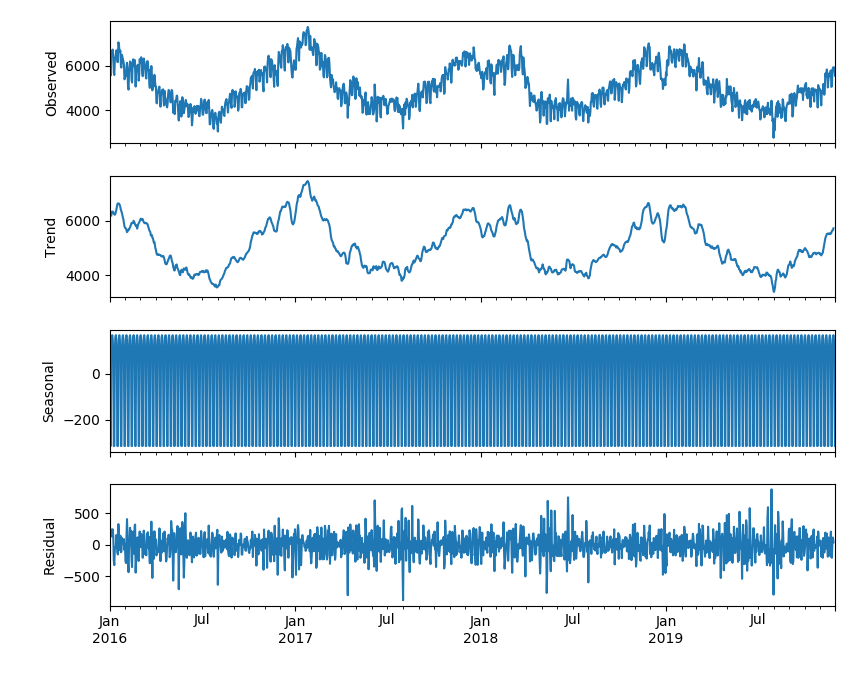

In [578]:
decomposer.plot()
plt.show()

<IPython.core.display.Javascript object>


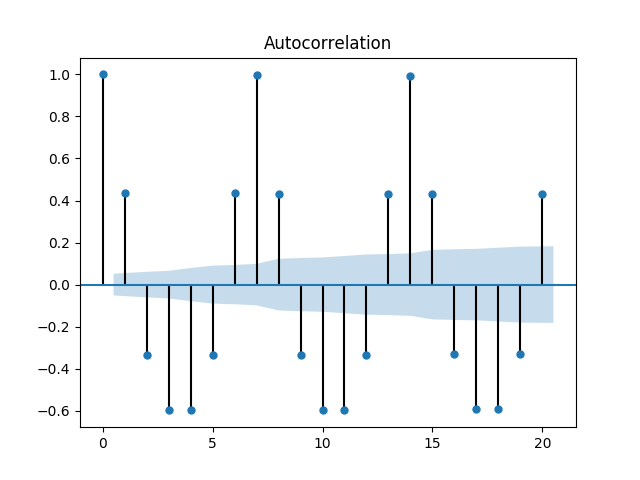

In [594]:
plot_acf(decomposer.seasonal, lags=20)
plt.show()

In [582]:
plot_time_series(df_detrended-decomposer.seasonal-decomposer.trend, 
                 y_columns=['Load [MW]'], 
                 title='Detrended time series', 
                 y_axis_title='daily energy demand [MW]')

# Causality testing

The question we want to answer here is which time series causes another. In order to do this, we will fix the time series we want to make predictions. Then we shift another time series and calculate the correlation between the two to find the shift that gives us the highest correlation. Giotto-time then allows us to transform the dataframe by shifting each column by the best value. 

In [498]:
shifter_3 = ShiftFeature(shift=3, output_name='shift_3')
shifter_8 = ShiftFeature(shift=8, output_name='shift_8')
time_series_shifted_3 = shifter_3.transform(time_series)
time_series_shifted_8 = shifter_8.transform(time_series)
df_causality = pd.concat([time_series, time_series_shifted_8, time_series_shifted_3], axis='columns', sort=False).fillna(value=0)
#time_series_random = 

Let's perform a causality test, i.e. let's try to find the shift necessary to optimize the linear fit coefficients.

As the two columns 'shift_3' and 'shift_8' are the same time series as the original one but with a shift of 3 and 8 respectively, in the best case we get a fit coefficient of 1 as can be seen in the dataframe below. 

In [499]:
cause = ShiftedLinearCoefficient(target_col="Load [MW]")
cause.fit(df_causality)
cause.max_corrs_

y,Load [MW],shift_3,shift_8
x,,,
Load [MW],0.729400,1.000000,1.000000
shift_3,0.510128,0.745460,1.000000
shift_8,0.557495,0.513738,0.851654


We can also look at the corresponding shifts directly. It turns out the test can successfully find the correct shifts 3 and 8. 

In [500]:
cause.best_shifts_

y,Load [MW],shift_3,shift_8
x,,,
Load [MW],1,3,8
shift_3,4,1,5
shift_8,1,1,1


This could be used to align two time series in a way that optimizes the predictive performance of one on the other without having to train and test the full model.

# Feature Creation

In [501]:
parameters = {'horizon': 100,
              'kernel': [1,1],
              'test_horizon': 10}

In [502]:
calendar = CalendarFeature(output_name='calendar', 
                           region='europe', 
                           country='Switzerland', 
                           kernel=parameters['kernel'], 
                           start_date=time_series_train.index.min())


holidays = calendar.transform()

In [595]:
# List of all features
year_period = PeriodicSeasonalFeature(output_name='yearly_season', period='365 days')
year_month = PeriodicSeasonalFeature(output_name='yearly_season', period='30 days')
week_period = PeriodicSeasonalFeature(output_name='day_season', period='7 days')
mv_avg_2 = MovingAverageFeature(window_size=2, output_name='moving_average_2')
mv_avg_10 = MovingAverageFeature(window_size=2, output_name='moving_average_10')
shift_10 = ShiftFeature(shift=10, output_name='shift_10')

features_creation = FeatureCreation(
    horizon=parameters['horizon'],
    time_series_features = [
        year_period,
        week_period,
        mv_avg_10,
        shift_10,
    ]
)

X, y = features_creation.fit_transform(time_series_train)
X = X.join(holidays)
# Caution: the season starts from 0 again for the test set: phase shift is not done!

Float64Index([                  0.0, 0.0027397260273972603,
               0.005479452054794521,   0.00821917808219178,
               0.010958904109589041,    0.0136986301369863,
                0.01643835616438356,  0.019178082191780823,
               0.021917808219178082,  0.024657534246575342,
              ...
                 2.8904109589041096,     2.893150684931507,
                 2.8958904109589043,    2.8986301369863012,
                 2.9013698630136986,     2.904109589041096,
                 2.9068493150684933,    2.9095890410958902,
                 2.9123287671232876,     2.915068493150685],
             dtype='float64', length=1065)
Float64Index([                0.0, 0.14285714285714285,  0.2857142857142857,
              0.42857142857142855,  0.5714285714285714,  0.7142857142857143,
               0.8571428571428571,                 1.0,  1.1428571428571428,
               1.2857142857142858,
              ...
               150.71428571428572,  150.85714285714286

In [ ]:
shift_10.trans

In [596]:
X_test, y_test = features_creation.transform(time_series_test)
X_test = X_test.join(holidays)
X_test = X_test.dropna()

Float64Index([                  0.0, 0.0027397260273972603,
               0.005479452054794521,   0.00821917808219178,
               0.010958904109589041,    0.0136986301369863,
                0.01643835616438356,  0.019178082191780823,
               0.021917808219178082,  0.024657534246575342,
              ...
                 0.9726027397260274,    0.9753424657534246,
                 0.9780821917808219,    0.9808219178082191,
                 0.9835616438356164,    0.9863013698630136,
                  0.989041095890411,    0.9917808219178083,
                 0.9945205479452055,    0.9972602739726028],
             dtype='float64', length=365)
Float64Index([                0.0, 0.14285714285714285,  0.2857142857142857,
              0.42857142857142855,  0.5714285714285714,  0.7142857142857143,
               0.8571428571428571,                 1.0,  1.1428571428571428,
               1.2857142857142858,
              ...
               50.714285714285715,  50.857142857142854,

# Prediction

In [597]:
featuresplitter = FeatureSplitter()
X_train, y_train, _, _ = featuresplitter.transform(X, y)

In [598]:
time_series_model = GAR(base_model=LassoCV())
time_series_model.fit(X_train, y_train)
predictions = time_series_model.predict(X_test.dropna())

In [599]:
# Plot predictions vs. reality
plot_data = pd.DataFrame(y_test['y_{}'.format(parameters['test_horizon'])].dropna())
plot_data.columns = ['reference']

plot_data = plot_data.join(predictions['y_{}'.format(parameters['test_horizon'])])

plot_data.index = y_test['y_{}'.format(parameters['test_horizon'])].dropna().index
plot_data = plot_data.dropna()

plot_data.columns = ['reference', 'prediction']

plot_time_series(plot_data, 
                 y_columns=['reference', 'prediction'], 
                 title='Predictions vs. Reference Values', 
                 y_axis_title='daily energy demand [MW]')

Note that predictions were made for all time steps not only for the ones that we have data for in y_test. This score calculated below is 

In [600]:
score = calculate_score(y_test, predictions)
score

502.05888942434746

In [601]:
rel_score = calculate_score(y_test, predictions, relative_mean_absolute_error)
rel_score

0.1088330444117621

In [602]:
y_naive = pd.DataFrame(np.ones(predictions.shape) * y_train.values.mean())

In [603]:
calculate_score(y_test, y_naive, relative_mean_absolute_error)

0.15030746442219609